In [3]:
from aiutils import *

import os
os.environ['GIT_PYTHON_REFRESH']='quiet' # So that mlflow does not WARN when lacking git

import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score
)

In [1]:
import sys
import os
import argparse
import json
import random
import torch
import glob
import mlflow

import numpy as np

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    median_absolute_error,
    r2_score
)


from aiutils import *

from train import Regressor, get_dataloader


#if __name__ == '__main__':    

/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.
  


In [6]:
class Args:
    def __init__(self):
        self.weights='model/soya.pt'
        self.outputpath='model'
        self.instrument='CBOT.ZS'
        self.random_state=123
        self.num_workers=1

opt = Args()

In [7]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

df = add_features(read_data())

df_obs = df[df['observation']=='Settle']

feats = ['Ndays', 'Nmatmonth', 'Nmatyear']

X = df_obs[df_obs['instrument']==opt.instrument][feats]
y = df_obs[df_obs['instrument']==opt.instrument][['value']]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,random_state=opt.random_state)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,random_state=opt.random_state)

train_dataloader = get_dataloader(
    X_train, y_train,
    batch_size=int(10e10),
    num_workers=1
)

vali_dataloader = get_dataloader(
    X_val, y_val,
    batch_size=int(10e10),
    num_workers=1
)

test_dataloader = get_dataloader(
    X_test, y_test,
    batch_size=int(10e10),
    num_workers=1
)

print('Building model...')

model = Regressor(
    num_features=len(feats),
    n_output=1
)

model.load_state_dict( torch.load(opt.weights) )

model.eval()
model.to(device)

for enu,dataloader in enumerate([
    train_dataloader,
    vali_dataloader,
    test_dataloader
]):

    for sample in dataloader:

        x,y = sample['x'], sample['y']
        pred = model.forward(x.to(device))

        if enu==0:
            X_train['pred'] = [float(p) for p in pred.cpu().detach()]
        elif enu==1:
            X_val['pred'] = [float(p) for p in pred.cpu().detach()]
        elif enu==2:
            X_test['pred'] = [float(p) for p in pred.cpu().detach()]

results = pd.DataFrame(data={
    'partition':['train','val','test'],
    'mean_abs_err':[mean_absolute_error(yy, xx['pred']) for xx,yy in zip([X_train, X_val, X_test],[y_train, y_val, y_test])],
    'mean_sqrt_err':[mean_squared_error(yy, xx['pred']) for xx,yy in zip([X_train, X_val, X_test],[y_train, y_val, y_test])],
    'median_abs_err':[median_absolute_error(yy, xx['pred']) for xx,yy in zip([X_train, X_val, X_test],[y_train, y_val, y_test])],
    'R2':[r2_score(yy, xx['pred']) for xx,yy in zip([X_train, X_val, X_test],[y_train, y_val, y_test])]
})

X_train['partition'] = 'train'
X_val['partition'] = 'val'
X_test['partition'] = 'test'

y_train['partition'] = 'train'
y_val['partition'] = 'val'
y_test['partition'] = 'test'

X = pd.concat([X_train, X_val, X_test])
y = pd.concat([y_train, y_val, y_test])

X['y'] = y.value

print([(yy, xx['pred']) for xx,yy in zip([X_test],[y_test])])
print(results)


Building model...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[(        value partition
5236  1360.25      test
7965  1239.25      test
6184  1291.75      test
3625  1391.25      test
5640  1465.25      test
...       ...       ...
6764  1406.00      test
1427  1212.25      test
8624  1243.75      test
8854  1250.00      test
5466  1548.50      test

[1153 rows x 2 columns], 5236    1397.299072
7965    1307.815186
6184    1180.207764
3625    1257.382568
5640    1406.955811
           ...     
6764    1389.981201
1427    1152.185791
8624    1406.230103
8854    1042.518677
5466    1274.807861
Name: pred, Length: 1153, dtype: float64)]
  partition  mean_abs_err  mean_sqrt_err  median_abs_err        R2
0     train    122.894457   23872.293675      104.713013 -0.976677
1       val    124.419903   24807.736041      106.884888 -1.025205
2      test    119.996149   23490.716744      100.756836 -0.917689


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [12]:
df_obs

,date,instrument,maturity,observation,value,currency,days,Ndays,Nmatmonth,Nmatyear,Ninstrument,maturity_month,maturity_year,Nobs
2,2021-01-04T00:00:00.000Z,CBOT.ZS,F2021,Settle,1316.50,USD,0,0.000000,0.000000,0.00,1,January,2021,0.5
5,2021-01-04T00:00:00.000Z,CBOT.ZS,H2021,Settle,1313.00,USD,0,0.000000,0.181818,0.00,1,March,2021,0.5
8,2021-01-04T00:00:00.000Z,CBOT.ZS,K2021,Settle,1311.25,USD,0,0.000000,0.363636,0.00,1,May,2021,0.5
11,2021-01-04T00:00:00.000Z,CBOT.ZS,N2021,Settle,1303.75,USD,0,0.000000,0.545455,0.00,1,July,2021,0.5
14,2021-01-04T00:00:00.000Z,CBOT.ZS,Q2021,Settle,1265.00,USD,0,0.000000,0.636364,0.00,1,August,2021,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19010,2021-12-01T00:00:00.000Z,CBOT.ZC,N2023,Settle,557.25,USD,331,0.906849,0.545455,0.50,0,July,2023,0.5
19013,2021-12-01T00:00:00.000Z,CBOT.ZC,U2023,Settle,515.75,USD,331,0.906849,0.727273,0.50,0,September,2023,0.5
19016,2021-12-01T00:00:00.000Z,CBOT.ZC,Z2023,Settle,507.50,USD,331,0.906849,1.000000,0.50,0,December,2023,0.5
19017,2021-12-01T00:00:00.000Z,CBOT.ZC,N2024,Settle,515.75,USD,331,0.906849,0.545455,0.75,0,July,2024,0.5


In [18]:
X['maturity_month']=df_obs['maturity_month']
X['maturity_year']=df_obs['maturity_year']
X['value'] = X['y']

In [19]:
X.columns

Index(['Ndays', 'Nmatmonth', 'Nmatyear', 'pred', 'partition', 'y',
       'instrument', 'maturity_month', 'maturity_year', 'value'],
      dtype='object')

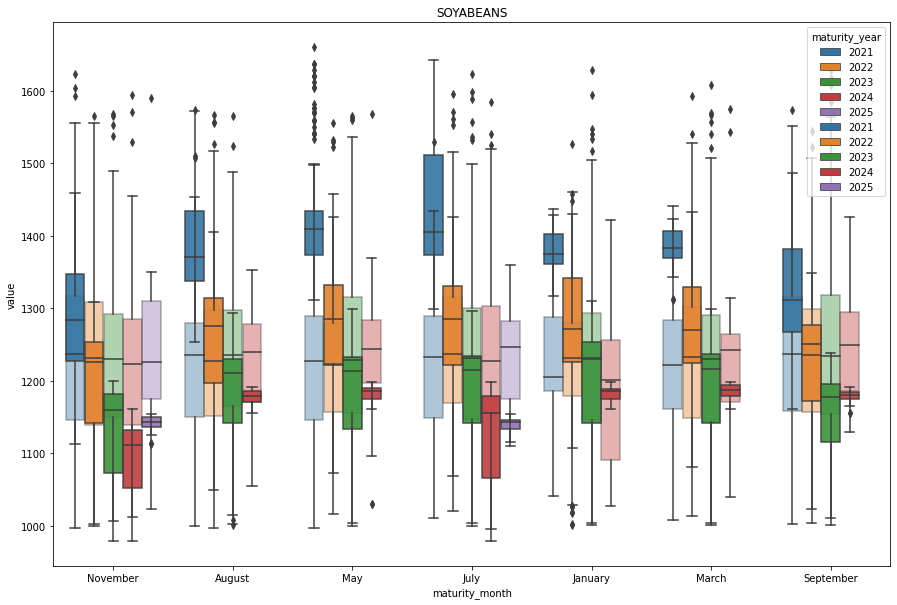

In [20]:
X['instrument']='CBOT.ZS'
plot_prediciton_vs_gt(X)